In [1]:
# install.packages("coin")
require(coin)

Lade nötiges Paket: coin

Lade nötiges Paket: survival



### Functions

In [2]:
t_test <- function(data
                  ,...){
    t.test(value~group
           ,data
           ,...
          )
}

In [3]:
welch_test <- function(data
                  ,...){
    t.test(value~group
           ,data
           ,var.equal = FALSE
           ,...
          )
}

In [4]:
mann_whitney_u_test <- function(data
                               ,...){
    coin::wilcox_test(value~group
                      ,data
                      ,...
                     )
}

In [5]:
moods_median_test <- function(data
                             ,...){
    mood.test(value~group
              ,data
              ,...)
}

In [6]:
run_statistics <- function(experiment
                         ,groups_to_test = NA 
                          # If there are more than two groups in the dataset, by default all vs all groups will be tested. 
                          # Provide character vector in form of e.g. c("het vs WT", "KO vs WT") to perform only selected comparisons
                         ,adjustment_method = "bonferroni"
                          ){
    # read in data
    data <- read.csv(file = paste0("./input/"
                                  ,experiment
                                  ,".tsv"
                                  )
                    ,sep = "\t"
                     ,dec = ","
                    ,header = TRUE)
    print(str(data))
    cat('\n')
    
    # how many groups we have?
    groups <- unique(data$group)
    print("we have following groups in the data:")
    print(groups)
    cat('\n')
    
    all_vs_all <- (length(groups >2)) & is.na(groups_to_test) # TRUE or FALSE
    
    # do we have biological replicates?
    ### if yes, paired version will be used
    paired <- sum(!is.na(data$bio_rep)) # TRUE or FALSE
    if(paired) {print("data are paired observations")}
    cat('\n')

    # pick the correct test
    ### check the normality of distribution assumption in all groups
    print("run Shapiro test to check the assumption of the distribution normality...")
    not_norm <- sapply(groups
                   ,function(group){
                       idx_group <- data$group == group
                       pvalue <- shapiro.test(data$value[idx_group])$p.value
                       
                       print(group)
                       ifelse(pvalue <= 0.05,print("non-normal"),print("normal"))
                       pvalue <= 0.05
                   })
    norm_dist <- sum(not_norm)== 0 # TRUE or FALSE
    print("overall distribution is:")
    ifelse(norm_dist,print("normal"),print("non-normal")) 
    cat('\n')
    
    ### check the homogeneity of variance assumption in all groups
    not_homogeneic <- if(norm_dist){
        print("run Bartlett test to check the assumption of the variance homogeneity...")
        pvalue <- bartlett.test(value~group, data = data)$p.value 
        pvalue <= 0.05
    } else {
        print("run Fligner-Killeen test to check the assumption of the variance homogeneity...")
        pvalue <- fligner.test(value~group, data = data)$p.value 
        pvalue <= 0.05
    }
    
    homo_var <- sum(not_homogeneic)== 0 # TRUE or FALSE
    print("overall variance is:") 
    ifelse(homo_var,print("stable"),print("non-stable")) 
    
    ### pick the test
    which_test <- if(norm_dist){ 
        ifelse(homo_var
              ,"t-test"  # distribution is normal, variance is stable
              ,"Welch test"  # distribution is normal, variance is not stable
              )
    }else {
        ifelse(homo_var
              ,"Mann-Whitney U-test"  # distribution is not normal, variance is stable
              ,"Mood's Median-test" # distribution is not normal, variance is not stable
              )
    }
    
    ### run the test
    run_one_comparison <- function(data){
        if(which_test == "t-test"){
            t_test(data, paired = paired)$p.value
    } else if(which_test == "Welch test"){
        welch_test(data, paired = paired)$p.value
    } else if(which_test == "Mann-Whitney U-test"){
        pvalue(mann_whitney_u_test(data, paired = paired))
    } else if(which_test == "Mood's Median-test"){
        moods_median_test(data)$p.value
    } else error("ERROR: undefined test")
        }
    
    p.values <- sapply(groups_to_test
                      ,function(comparison){
                          group1 <- sub(" vs .*","",comparison)
                          group2 <- sub(".* vs ","",comparison)
                          
                          idx <- data$group %in% c(group1, group2)
                          data_sub <- data[idx,]
                          # make the group column values as factor
                          data_sub$group <- as.factor(data_sub$group)
                          run_one_comparison(data_sub)
                      })
    
    # adjust for multiple testing if needed
    p.adjs <- p.adjust(p.values
                      ,method = adjustment_method)
        
    
    output <- data.frame(comparison = groups_to_test
                        ,p.value = p.values)
        
    if(length(groups_to_test)> 1){output$p.adj = p.adjs}
    
    # print mesages
    
    cat('\n')
    print(paste0("Since the normality of distribution assumption is "
                ,ifelse(norm_dist
                       ,"met"
                       ,"not met"
                       )
                 ," and the homogeneity of variace assumption is "
                 ,ifelse(homo_var
                        ,"met"
                        ,"not met"
                        )
                 ,", we use the "
                 ,which_test
                 ,"."
                )
         )
    
    cat('\n')
    if(paired){print(paste0("Since we have several independent biological replicates as paired observations across groups, we use the paired version of the "
                           ,which_test
                           ," test.")
                    )}
    
    
    cat('\n')
    print("We are doing the comparison of the following group(s):")
    print(ifelse(all_vs_all
          ,"all vs all"
          ,groups_to_test))
    
    
    cat('\n')    
    print(output)

    # export results
        write.table(output
                 ,file = paste0("./output/"
                                ,experiment
                                ,"_stats.tsv"
                                )
                 ,sep = "\t"
                 ,quote = FALSE
                 ,col.names = TRUE
                 ,row.names = FALSE)
    
}

In [7]:
# linear regression
run_regression <- function(experiment
                           ,formula
                           ,data
                           ,adjustment_method = "bonferroni"
                          ,export_results = TRUE
                          ){
    fit <- lm(formula, data)
    
    print(plot(fit))
    
    print(summary(fit))
    # export results
    output <- as.data.frame(summary(fit)$coefficients)
    
    # adjust for multiple testing if needed
    groups <- unique(data$genotype)
    if(length(groups)> 1){
        output$p.adj <- p.adjust(output[,'Pr(>|t|)']
                                ,method = adjustment_method)
    }
    
    print(output)
    if(export_results){
        write.table(output
                 ,file = paste0("./output/"
                                ,experiment
                                ,"_stats.tsv"
                                )
                 ,sep = "\t"
                 ,quote = FALSE
                 ,col.names = TRUE
                 ,row.names = TRUE)
    }
    fit
}

### Run analysis

In [8]:
run_statistics("Fig1C_DGEP"
              ,groups_to_test = "MUT vs WT")

'data.frame':	51 obs. of  5 variables:
 $ value  : num  67.3 51.3 85.5 135.6 52.7 ...
 $ group  : chr  "WT" "WT" "WT" "WT" ...
 $ tec_rep: logi  NA NA NA NA NA NA ...
 $ bio_rep: logi  NA NA NA NA NA NA ...
 $ date   : logi  NA NA NA NA NA NA ...
NULL

[1] "we have following groups in the data:"
[1] "WT"  "MUT"


[1] "run Shapiro test to check the assumption of the distribution normality..."
[1] "WT"
[1] "non-normal"
[1] "MUT"
[1] "normal"
[1] "overall distribution is:"
[1] "non-normal"

[1] "run Fligner-Killeen test to check the assumption of the variance homogeneity..."
[1] "overall variance is:"
[1] "stable"

[1] "Since the normality of distribution assumption is not met and the homogeneity of variace assumption is met, we use the Mann-Whitney U-test."


[1] "We are doing the comparison of the following group(s):"
[1] "MUT vs WT"

          comparison  p.value
MUT vs WT  MUT vs WT 0.168587


In [9]:
run_statistics("Fig1D_QMI"
              ,groups_to_test = "MUT vs WT")

'data.frame':	43 obs. of  5 variables:
 $ value  : int  79 91 75 82 86 77 79 82 68 79 ...
 $ group  : chr  "WT" "WT" "WT" "WT" ...
 $ tec_rep: logi  NA NA NA NA NA NA ...
 $ bio_rep: logi  NA NA NA NA NA NA ...
 $ date   : logi  NA NA NA NA NA NA ...
NULL

[1] "we have following groups in the data:"
[1] "WT"  "MUT"


[1] "run Shapiro test to check the assumption of the distribution normality..."
[1] "WT"
[1] "normal"
[1] "MUT"
[1] "normal"
[1] "overall distribution is:"
[1] "normal"

[1] "run Bartlett test to check the assumption of the variance homogeneity..."
[1] "overall variance is:"
[1] "non-stable"

[1] "Since the normality of distribution assumption is met and the homogeneity of variace assumption is not met, we use the Welch test."


[1] "We are doing the comparison of the following group(s):"
[1] "MUT vs WT"

          comparison     p.value
MUT vs WT  MUT vs WT 0.003058479


In [10]:
run_statistics("Fig2B_FACS_OCI-Ly1"
              ,groups_to_test = c("het vs WT"
                                 ,"KO vs WT"
                                 )
              )

'data.frame':	9 obs. of  5 variables:
 $ value  : num  17.4 14.5 13 2.8 2.24 1.84 1.8 1.84 1.38
 $ group  : chr  "WT" "WT" "WT" "het" ...
 $ tec_rep: int  1 2 3 1 2 3 1 2 3
 $ bio_rep: logi  NA NA NA NA NA NA ...
 $ date   : int  NA 20200507 20200514 NA 20200507 20200514 NA 20200507 20200514
NULL

[1] "we have following groups in the data:"
[1] "WT"  "het" "KO" 


[1] "run Shapiro test to check the assumption of the distribution normality..."
[1] "WT"
[1] "normal"
[1] "het"
[1] "normal"
[1] "KO"
[1] "normal"
[1] "overall distribution is:"
[1] "normal"

[1] "run Bartlett test to check the assumption of the variance homogeneity..."
[1] "overall variance is:"
[1] "non-stable"

[1] "Since the normality of distribution assumption is met and the homogeneity of variace assumption is not met, we use the Welch test."


[1] "We are doing the comparison of the following group(s):"
[1] "het vs WT" "KO vs WT" 

          comparison     p.value      p.adj
het vs WT  het vs WT 0.007950932 0.01590186


In [11]:
run_statistics("Fig2B_FACS_OCI-Ly8"
              ,groups_to_test = c("het vs WT"
                                 ,"KO vs WT"
                                 ,"het+ARID1A vs WT")
              )

'data.frame':	12 obs. of  5 variables:
 $ value  : num  21 18 14.4 3.7 5.81 4.37 2.4 3.05 1.72 17.2 ...
 $ group  : chr  "WT" "WT" "WT" "het" ...
 $ tec_rep: int  1 2 3 1 2 3 1 2 3 1 ...
 $ bio_rep: logi  NA NA NA NA NA NA ...
 $ date   : int  NA 20200507 20200514 NA 20200507 20200514 NA 20200507 20200514 NA ...
NULL

[1] "we have following groups in the data:"
[1] "WT"         "het"        "KO"         "het+ARID1A"


[1] "run Shapiro test to check the assumption of the distribution normality..."
[1] "WT"
[1] "normal"
[1] "het"
[1] "normal"
[1] "KO"
[1] "normal"
[1] "het+ARID1A"
[1] "normal"
[1] "overall distribution is:"
[1] "normal"

[1] "run Bartlett test to check the assumption of the variance homogeneity..."
[1] "overall variance is:"
[1] "stable"

[1] "Since the normality of distribution assumption is met and the homogeneity of variace assumption is met, we use the t-test."


[1] "We are doing the comparison of the following group(s):"
[1] "het vs WT"        "KO vs WT"         "h

In [12]:
run_statistics("Fig2E_qPCR_OCI-Ly1_raw"
              ,groups_to_test = c("het vs WT"
                                 ,"KO vs WT"
                                 )
              )

'data.frame':	9 obs. of  5 variables:
 $ value  : num  5.96 5.63 2.65 7.21 6.2 5.83 8.09 6.17 7.38
 $ group  : chr  "WT" "WT" "WT" "het" ...
 $ tec_rep: chr  "exp1" "exp2" "exp3" "exp1" ...
 $ bio_rep: chr  "exp1" "exp2" "exp3" "exp1" ...
 $ date   : logi  NA NA NA NA NA NA ...
NULL

[1] "we have following groups in the data:"
[1] "WT"  "het" "KO" 

[1] "data are paired observations"

[1] "run Shapiro test to check the assumption of the distribution normality..."
[1] "WT"
[1] "normal"
[1] "het"
[1] "normal"
[1] "KO"
[1] "normal"
[1] "overall distribution is:"
[1] "normal"

[1] "run Bartlett test to check the assumption of the variance homogeneity..."
[1] "overall variance is:"
[1] "stable"

[1] "Since the normality of distribution assumption is met and the homogeneity of variace assumption is met, we use the t-test."

[1] "Since we have several independent biological replicates as paired observations across groups, we use the paired version of the t-test test."

[1] "We are doing the c

In [13]:
run_statistics("Fig2E_qPCR_OCI-Ly8_raw"
              ,groups_to_test = c("het vs WT"
                                 ,"KO vs WT"
                                 ,"het+ARID1A vs WT")
              )

'data.frame':	12 obs. of  5 variables:
 $ value  : num  6.89 5.14 5.18 7.16 6.39 6.7 8.14 6.89 6.88 6.67 ...
 $ group  : chr  "WT" "WT" "WT" "het" ...
 $ tec_rep: chr  "exp1" "exp2" "exp3" "exp1" ...
 $ bio_rep: chr  "exp1" "exp2" "exp3" "exp1" ...
 $ date   : logi  NA NA NA NA NA NA ...
NULL

[1] "we have following groups in the data:"
[1] "WT"         "het"        "KO"         "het+ARID1A"

[1] "data are paired observations"

[1] "run Shapiro test to check the assumption of the distribution normality..."
[1] "WT"
[1] "non-normal"
[1] "het"
[1] "normal"
[1] "KO"
[1] "non-normal"
[1] "het+ARID1A"
[1] "normal"
[1] "overall distribution is:"
[1] "non-normal"

[1] "run Fligner-Killeen test to check the assumption of the variance homogeneity..."
[1] "overall variance is:"
[1] "stable"

[1] "Since the normality of distribution assumption is not met and the homogeneity of variace assumption is met, we use the Mann-Whitney U-test."

[1] "Since we have several independent biological replicates

In [14]:
run_statistics("Fig3E_qPCR_OCI-Ly1_raw"
              ,groups_to_test = c("het vs WT"
                                 ,"KO vs WT"
                                 )
              )

'data.frame':	9 obs. of  5 variables:
 $ value  : num  2.44 6.77 5.97 5.45 7.51 7.81 7.88 7.08 8.21
 $ group  : chr  "WT" "WT" "WT" "het" ...
 $ tec_rep: chr  "exp 1" "exp 2" "exp 3" "exp 1" ...
 $ bio_rep: chr  "exp 1" "exp 2" "exp 3" "exp 1" ...
 $ date   : logi  NA NA NA NA NA NA ...
NULL

[1] "we have following groups in the data:"
[1] "WT"  "het" "KO" 

[1] "data are paired observations"

[1] "run Shapiro test to check the assumption of the distribution normality..."
[1] "WT"
[1] "normal"
[1] "het"
[1] "normal"
[1] "KO"
[1] "normal"
[1] "overall distribution is:"
[1] "normal"

[1] "run Bartlett test to check the assumption of the variance homogeneity..."
[1] "overall variance is:"
[1] "stable"

[1] "Since the normality of distribution assumption is met and the homogeneity of variace assumption is met, we use the t-test."

[1] "Since we have several independent biological replicates as paired observations across groups, we use the paired version of the t-test test."

[1] "We are do

In [15]:
run_statistics("Fig3E_qPCR_OCI-Ly8_raw"
              ,groups_to_test = c("het vs WT"
                                 ,"KO vs WT"
                                 ,"het+ARID1A vs WT")
              )

'data.frame':	12 obs. of  5 variables:
 $ value  : num  7 6.34 6.31 7.87 8.48 8.32 8.04 7.6 6.95 7.36 ...
 $ group  : chr  "WT" "WT" "WT" "het" ...
 $ tec_rep: chr  "exp 1" "exp 2" "exp 3" "exp 1" ...
 $ bio_rep: chr  "exp 1" "exp 2" "exp 3" "exp 1" ...
 $ date   : logi  NA NA NA NA NA NA ...
NULL

[1] "we have following groups in the data:"
[1] "WT"         "het"        "KO"         "het+ARID1A"

[1] "data are paired observations"

[1] "run Shapiro test to check the assumption of the distribution normality..."
[1] "WT"
[1] "normal"
[1] "het"
[1] "normal"
[1] "KO"
[1] "normal"
[1] "het+ARID1A"
[1] "normal"
[1] "overall distribution is:"
[1] "normal"

[1] "run Bartlett test to check the assumption of the variance homogeneity..."
[1] "overall variance is:"
[1] "stable"

[1] "Since the normality of distribution assumption is met and the homogeneity of variace assumption is met, we use the t-test."

[1] "Since we have several independent biological replicates as paired observations across 

'data.frame':	12 obs. of  7 variables:
 $ value   : num  1.1 1.14 0.765 7.2 5.7 ...
 $ group   : chr  "0 ng" "0 ng" "0 ng" "50 ng" ...
 $ tec_rep : chr  "exp 1" "exp 2" "exp 3" "exp 1" ...
 $ bio_rep : logi  NA NA NA NA NA NA ...
 $ date    : logi  NA NA NA NA NA NA ...
 $ dose    : int  0 0 0 50 50 50 200 200 200 500 ...
 $ genotype: chr  "WT" "WT" "WT" "WT" ...
NULL


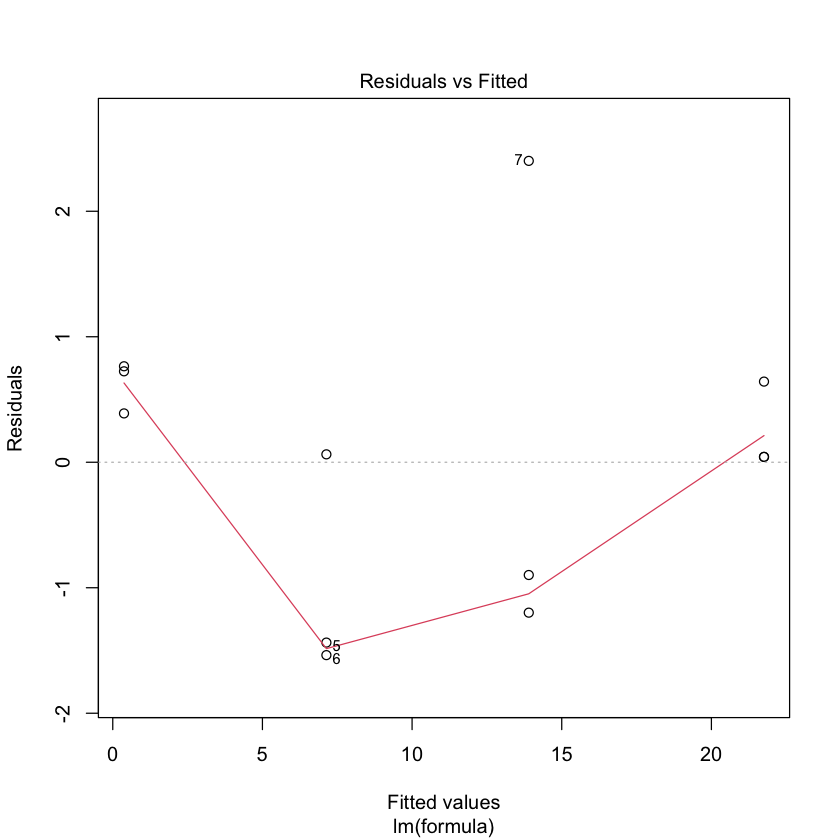

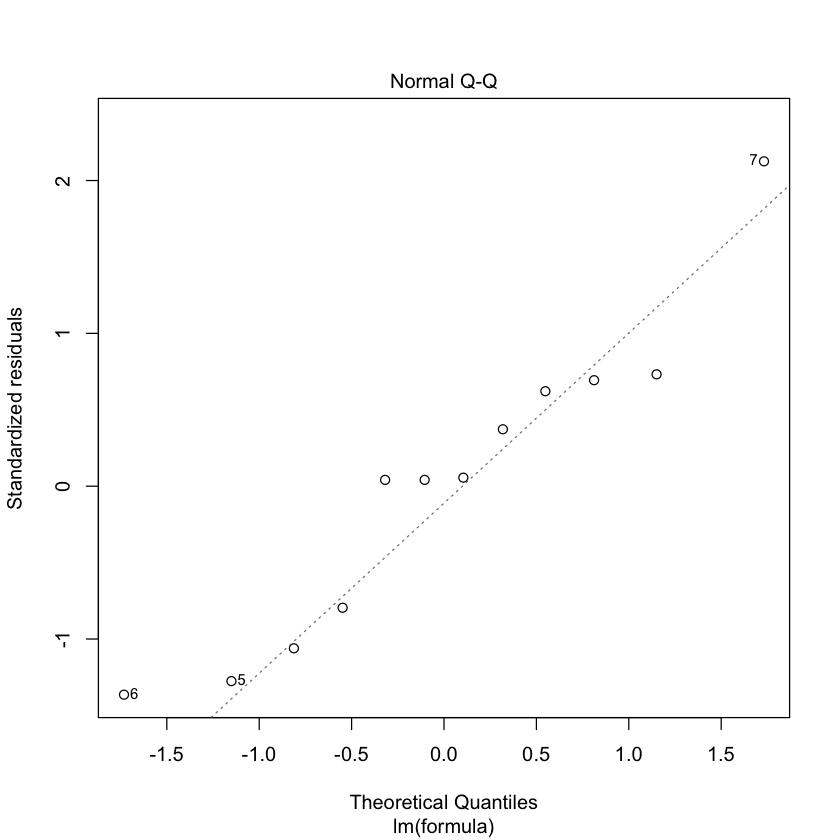

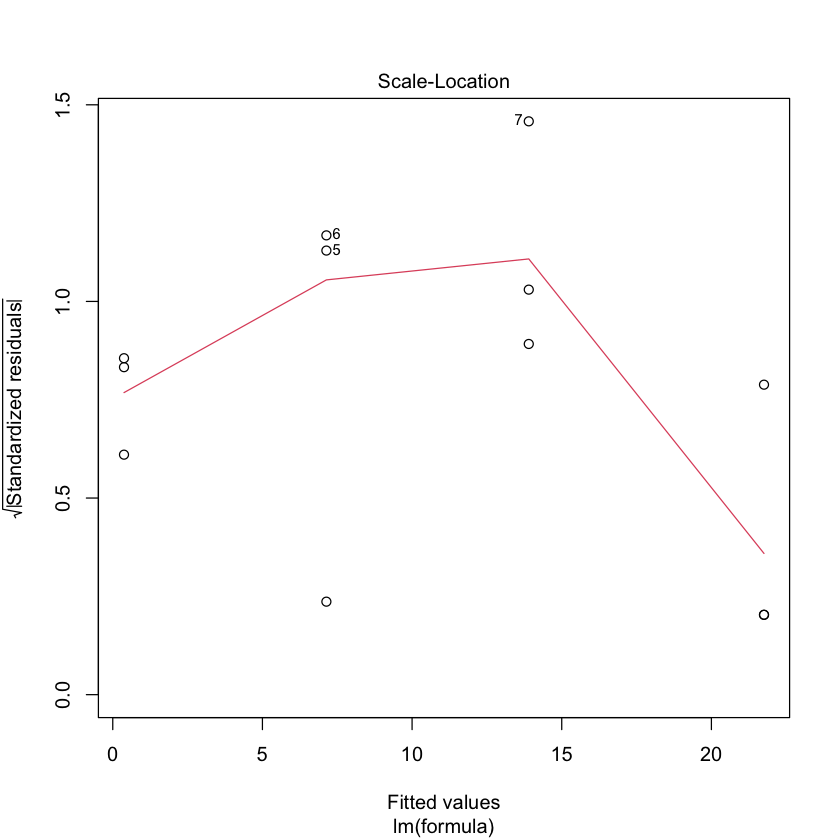

NULL

Call:
lm(formula = formula, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.53698 -0.97353  0.05284  0.66314  2.40147 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.37542    0.56615   0.663    0.522    
sqrt(dose)   0.95623    0.04135  23.128 5.16e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.188 on 10 degrees of freedom
Multiple R-squared:  0.9816,	Adjusted R-squared:  0.9798 
F-statistic: 534.9 on 1 and 10 DF,  p-value: 5.163e-10

             Estimate Std. Error    t value     Pr(>|t|)
(Intercept) 0.3754214 0.56615129  0.6631115 5.222503e-01
sqrt(dose)  0.9562283 0.04134584 23.1275545 5.163319e-10


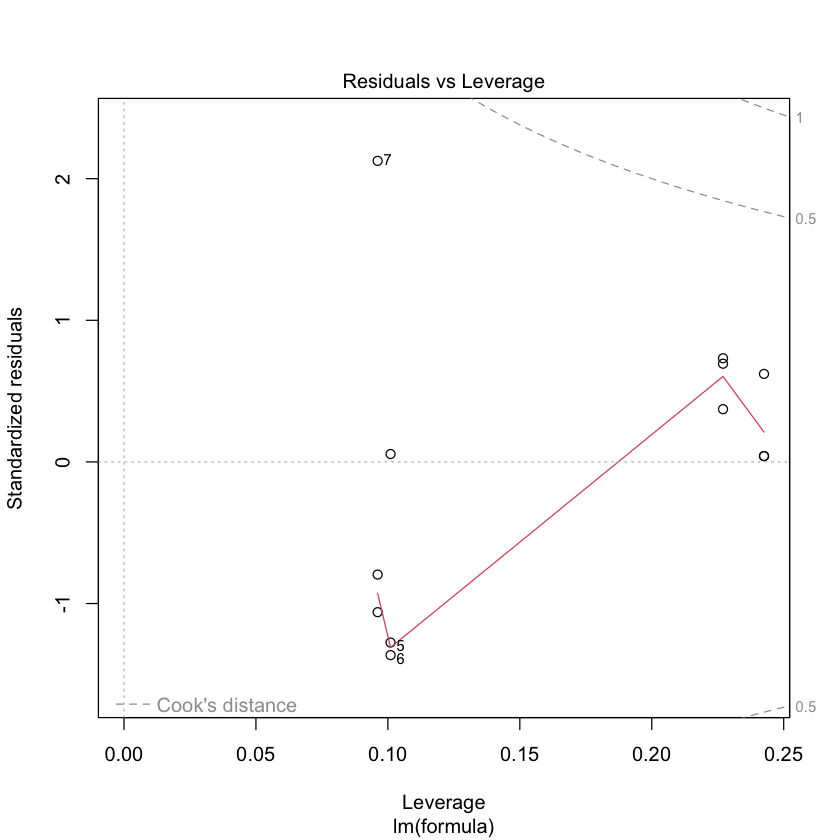

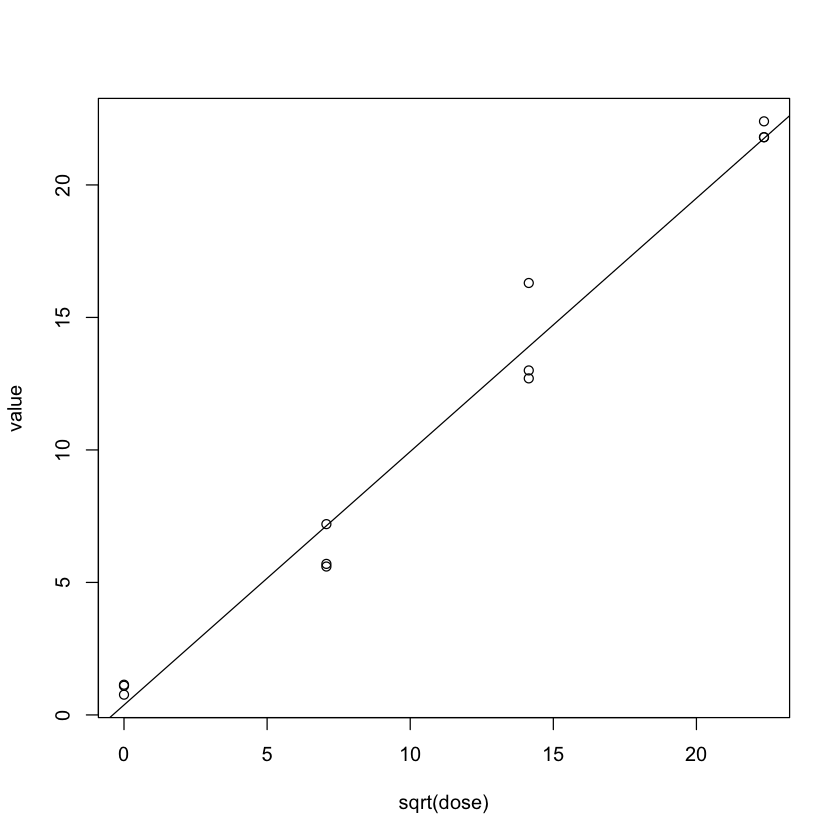

In [16]:
# "Fig4C_luc_promoter1" 
data <- read.csv(file = paste0("./input/"
                                  ,"Fig4C_luc_promoter1"
                                  ,".tsv"
                                  )
                    ,sep = "\t"
                     ,dec = ","
                    ,header = TRUE)
print(str(data))

fit <- run_regression("Fig4C_luc_promoter1"
                       ,formula = value~sqrt(dose)
                      ,data = data
                       ,export_results = TRUE
                       )

# plot 
plot(value~sqrt(dose), data)
abline(fit)

'data.frame':	12 obs. of  7 variables:
 $ value   : num  0.99 1.28 0.73 9.5 7.5 ...
 $ group   : chr  "0 ng" "0 ng" "0 ng" "50 ng" ...
 $ tec_rep : chr  "exp 1" "exp 2" "exp 3" "exp 1" ...
 $ bio_rep : logi  NA NA NA NA NA NA ...
 $ date    : logi  NA NA NA NA NA NA ...
 $ dose    : int  0 0 0 50 50 50 200 200 200 500 ...
 $ genotype: chr  "WT" "WT" "WT" "WT" ...
NULL


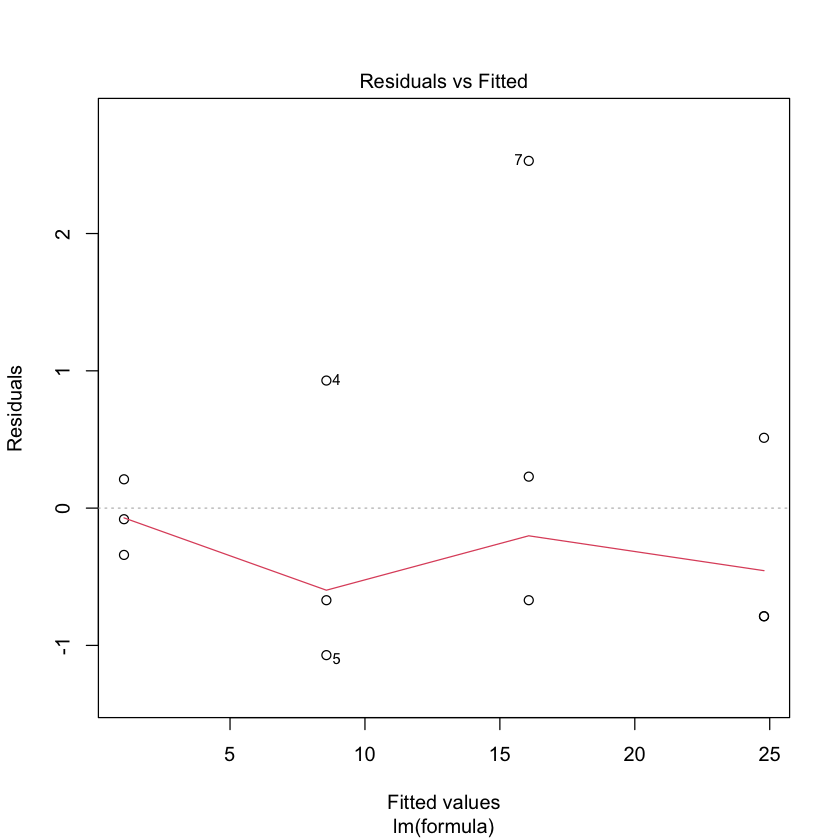

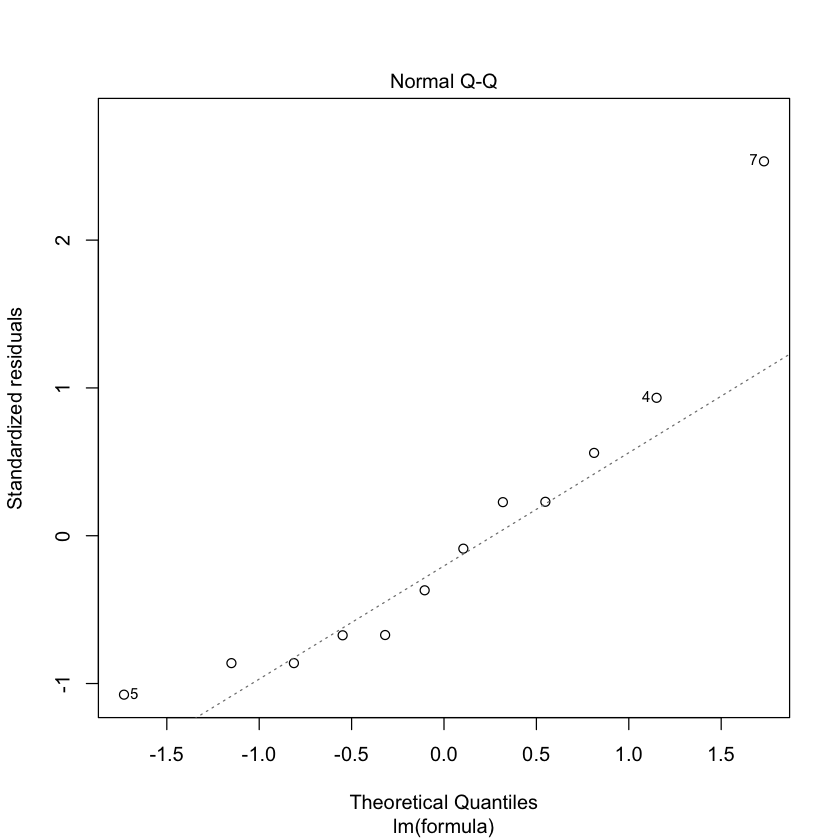

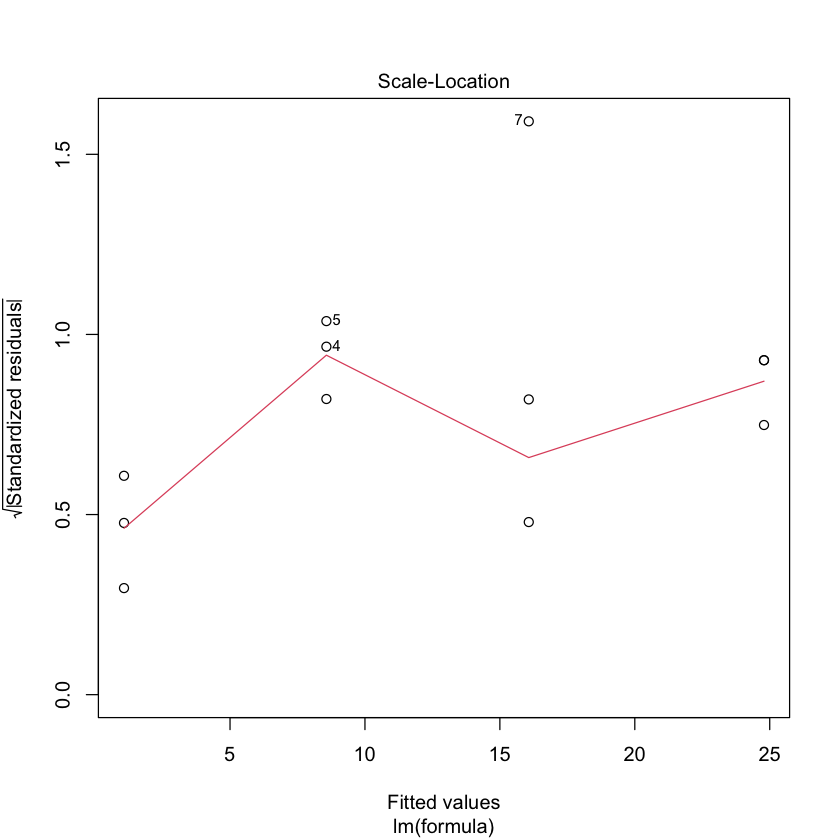

NULL

Call:
lm(formula = formula, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.0708 -0.7000 -0.2109  0.3000  2.5292 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.07081    0.50038    2.14    0.058 .  
sqrt(dose)   1.06066    0.03654   29.02 5.49e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.05 on 10 degrees of freedom
Multiple R-squared:  0.9883,	Adjusted R-squared:  0.9871 
F-statistic: 842.5 on 1 and 10 DF,  p-value: 5.494e-11

            Estimate Std. Error   t value     Pr(>|t|)
(Intercept) 1.070812 0.50037987  2.139998 5.803514e-02
sqrt(dose)  1.060657 0.03654258 29.025240 5.493544e-11


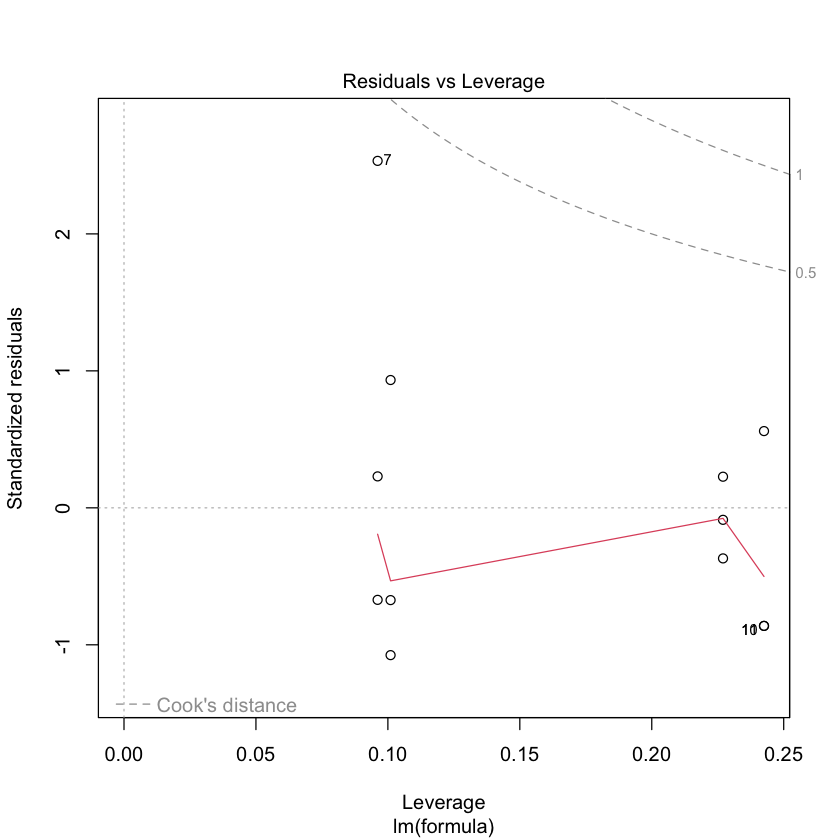

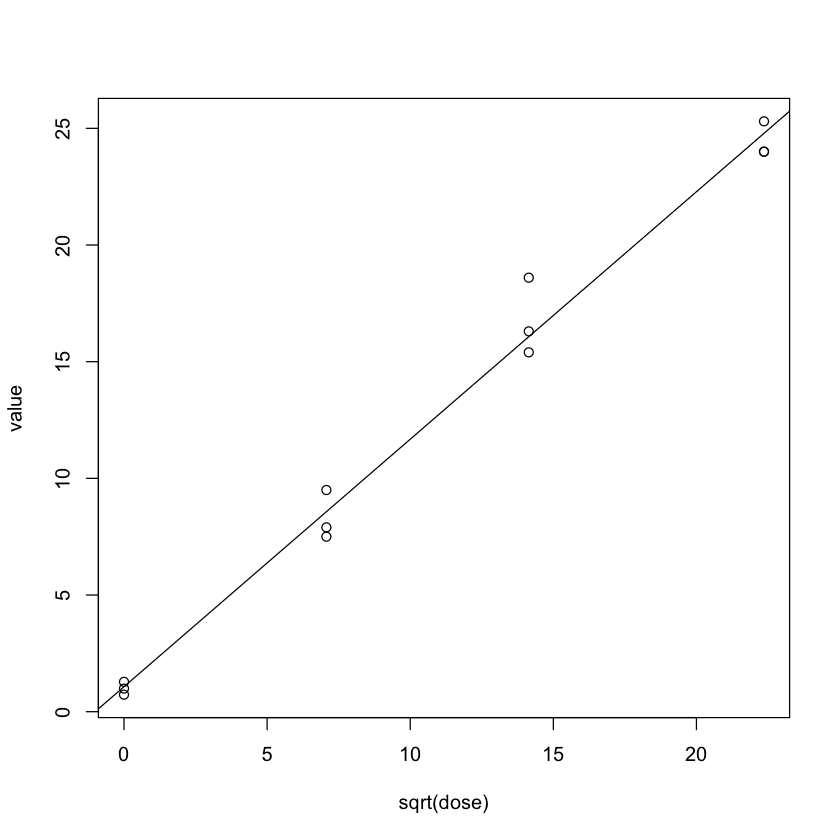

In [17]:
# "Fig4C_luc_promoter2" 
data <- read.csv(file = paste0("./input/"
                                  ,"Fig4C_luc_promoter2"
                                  ,".tsv"
                                  )
                    ,sep = "\t"
                     ,dec = ","
                    ,header = TRUE)
print(str(data))

fit <- run_regression("Fig4C_luc_promoter2"
                      ,formula = value~sqrt(dose)
                      ,data = data
                      ,export_results = TRUE
                       )

# plot 
plot(value~sqrt(dose), data)
abline(fit)

In [17]:
run_statistics("Fig4F_qPCR_OCI-Ly8_raw"
              ,groups_to_test = c("het vs WT"
                                  ,"het+RUNX3 vs WT"
                                  ,"KO vs WT"
                                 )
              )

'data.frame':	12 obs. of  5 variables:
 $ value  : num  0.965 1.005 0.678 1.695 1.66 ...
 $ group  : chr  "WT" "WT" "WT" "het" ...
 $ tec_rep: chr  "exp 1" "exp 2" "exp 3" "exp 1" ...
 $ bio_rep: logi  NA NA NA NA NA NA ...
 $ date   : logi  NA NA NA NA NA NA ...
NULL

[1] "we have following groups in the data:"
[1] "WT"        "het"       "het+RUNX3" "KO"       


[1] "run Shapiro test to check the assumption of the distribution normality..."
[1] "WT"
[1] "normal"
[1] "het"
[1] "normal"
[1] "het+RUNX3"
[1] "normal"
[1] "KO"
[1] "normal"
[1] "overall distribution is:"
[1] "normal"

[1] "run Bartlett test to check the assumption of the variance homogeneity..."
[1] "overall variance is:"
[1] "stable"

[1] "Since the normality of distribution assumption is met and the homogeneity of variace assumption is met, we use the t-test."


[1] "We are doing the comparison of the following group(s):"
[1] "het vs WT"       "het+RUNX3 vs WT" "KO vs WT"       

                     comparison     p.va

In [16]:
run_statistics("Fig4G_FACS_OCI-Ly8"
              ,groups_to_test = c("het vs WT"
                                  ,"het+RUNX3 vs WT"
                                  ,"KO vs WT"
                                 )
              )

'data.frame':	12 obs. of  5 variables:
 $ value  : num  20.5 22.8 18.3 13.4 16.5 9.72 31.1 29.9 14.8 7.6 ...
 $ group  : chr  "WT" "WT" "WT" "het" ...
 $ tec_rep: int  1 2 3 1 2 3 1 2 3 1 ...
 $ bio_rep: logi  NA NA NA NA NA NA ...
 $ date   : int  20210629 20210623 20210907 20210629 20210623 20210907 20210629 20210623 20210907 20210629 ...
NULL

[1] "we have following groups in the data:"
[1] "WT"        "het"       "het+RUNX3" "KO"       


[1] "run Shapiro test to check the assumption of the distribution normality..."
[1] "WT"
[1] "normal"
[1] "het"
[1] "normal"
[1] "het+RUNX3"
[1] "normal"
[1] "KO"
[1] "normal"
[1] "overall distribution is:"
[1] "normal"

[1] "run Bartlett test to check the assumption of the variance homogeneity..."
[1] "overall variance is:"
[1] "stable"

[1] "Since the normality of distribution assumption is met and the homogeneity of variace assumption is met, we use the t-test."


[1] "We are doing the comparison of the following group(s):"
[1] "het vs WT"     

'data.frame':	48 obs. of  7 variables:
 $ value   : num  3.34 2.5 2.86 4.68 4.17 ...
 $ group   : chr  "WT 0 ng" "WT 0 ng" "WT 0 ng" "het 0 ng" ...
 $ tec_rep : int  1 2 3 1 2 3 1 2 3 1 ...
 $ bio_rep : logi  NA NA NA NA NA NA ...
 $ date    : logi  NA NA NA NA NA NA ...
 $ dose    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ genotype: Factor w/ 4 levels "WT","het","het+RUNX3",..: 1 1 1 2 2 2 3 3 3 4 ...
NULL


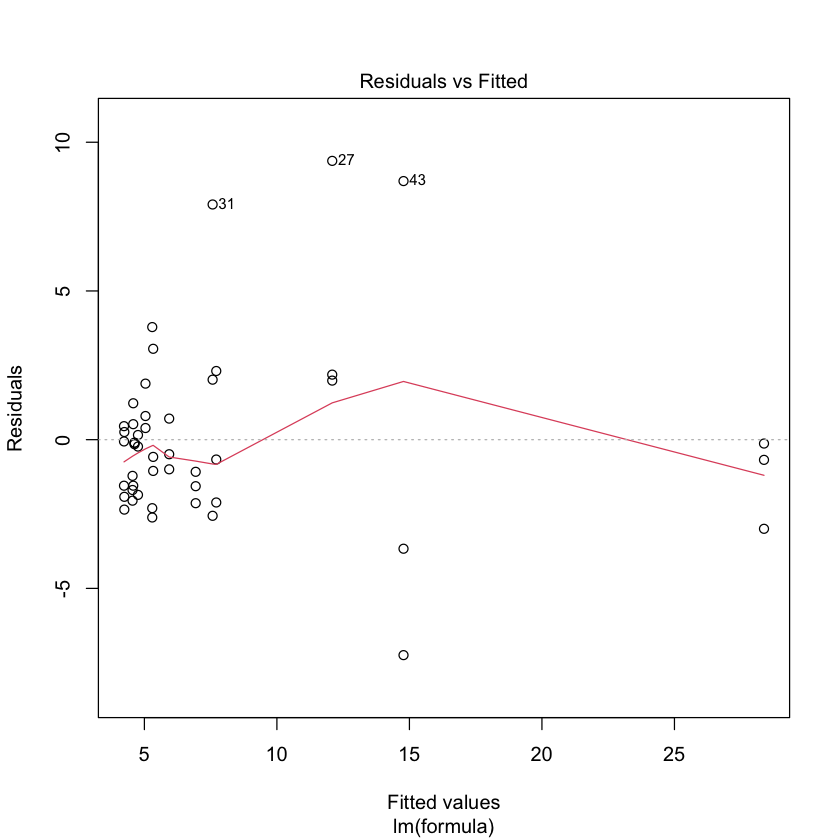

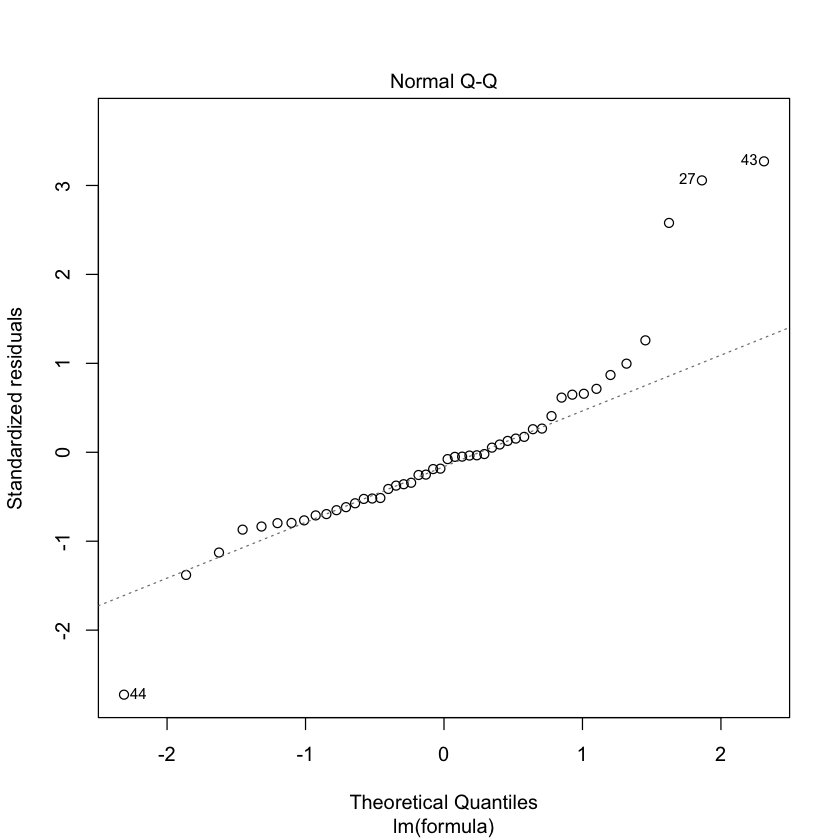

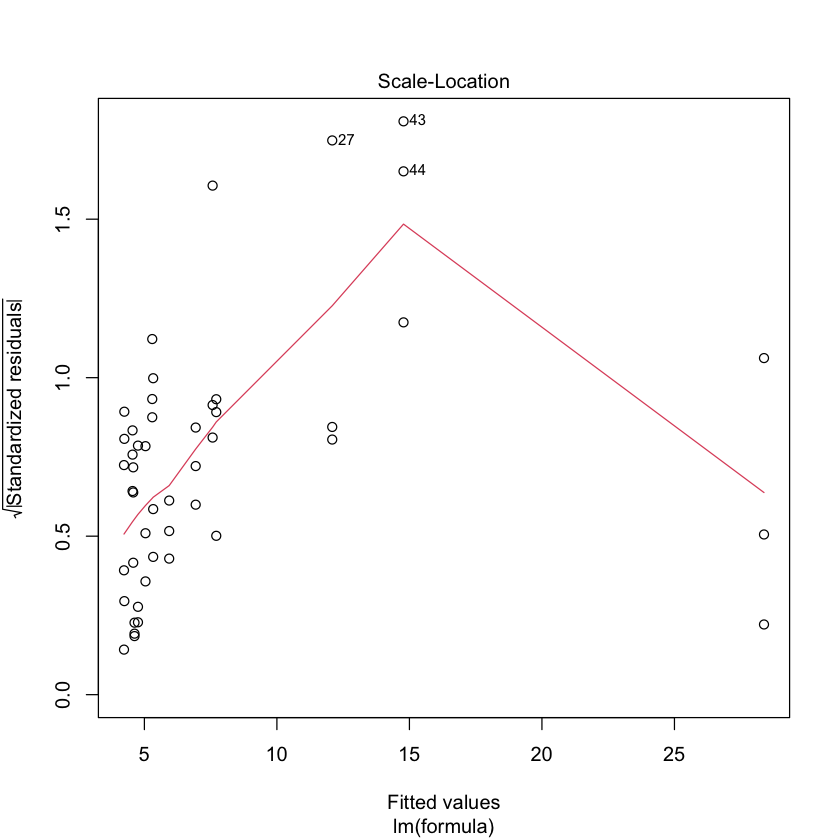

NULL

Call:
lm(formula = formula, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.2437 -1.7331 -0.3604  0.7300  9.3733 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   4.55316    1.24908   3.645 0.000761 ***
sqrt(dose)                    1.37557    0.13690  10.048 1.68e-12 ***
genotypehet                  -0.32231    1.76647  -0.182 0.856145    
genotypehet+RUNX3            -0.31006    1.76647  -0.176 0.861554    
genotypeKO                    0.07425    1.76647   0.042 0.966684    
sqrt(dose):genotypehet       -1.17460    0.19360  -6.067 3.80e-07 ***
sqrt(dose):genotypehet+RUNX3 -0.76738    0.19360  -3.964 0.000297 ***
sqrt(dose):genotypeKO        -1.30003    0.19360  -6.715 4.69e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.204 on 40 degrees of freedom
Multiple R-squared:  0.8092,	Adjusted R-squared:  0.7758 
F-statistic: 24.23 on 7 and 40 D

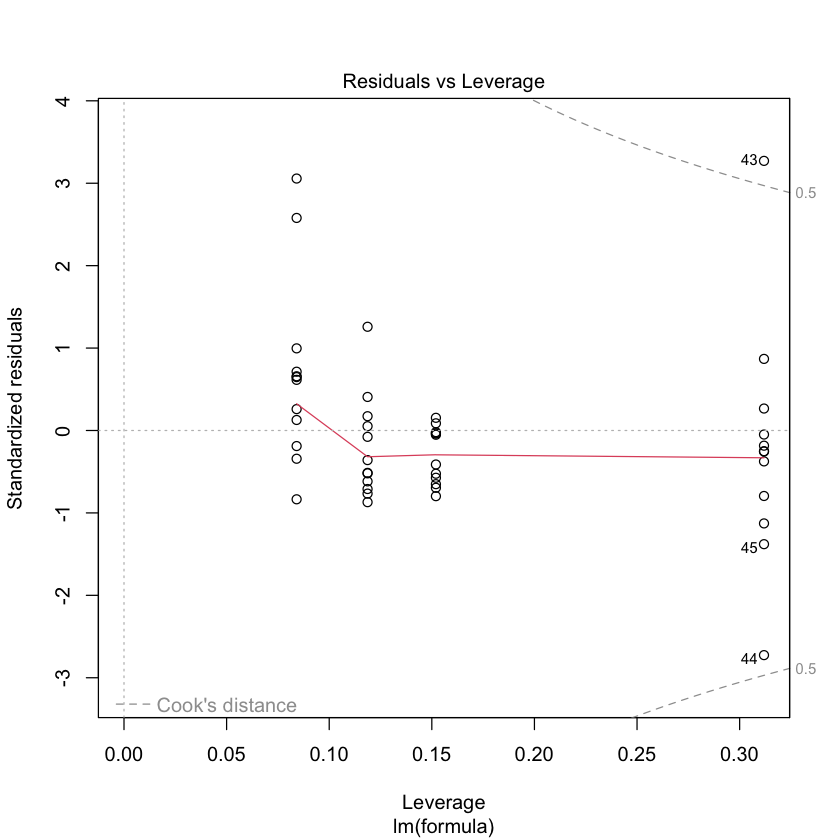

In [20]:
# "Fig5B_FACS_OCI-Ly1" 

data <- read.csv(file = paste0("./input/"
                                  ,"Fig5B_FACS_OCI-Ly1.tsv"
                                  )
                    ,sep = "\t"
                     ,dec = ","
                    ,header = TRUE)

data$genotype <- factor(data$genotype
                        , levels=c("WT", "het", "het+RUNX3", "KO" )
                       )
print(str(data))

fit <- run_regression("Fig5B_FACS_OCI-Ly1"
                       ,formula = value~sqrt(dose)*genotype
                      ,data = data
                       ,export_results = TRUE
                       )

'data.frame':	48 obs. of  7 variables:
 $ value   : num  6.27 3.18 2.65 2.29 1.42 ...
 $ group   : chr  "WT 0 ng" "WT 0 ng" "WT 0 ng" "het 0 ng" ...
 $ tec_rep : int  1 2 3 1 2 3 1 2 3 1 ...
 $ bio_rep : logi  NA NA NA NA NA NA ...
 $ date    : logi  NA NA NA NA NA NA ...
 $ dose    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ genotype: Factor w/ 4 levels "WT","het","het+RUNX3",..: 1 1 1 2 2 2 3 3 3 4 ...
NULL


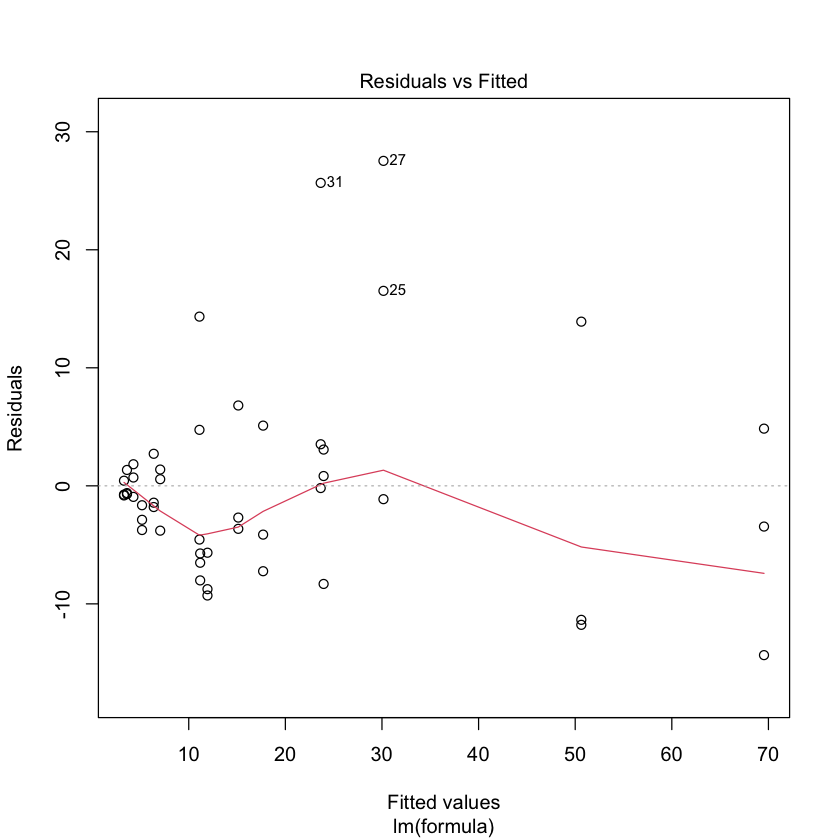

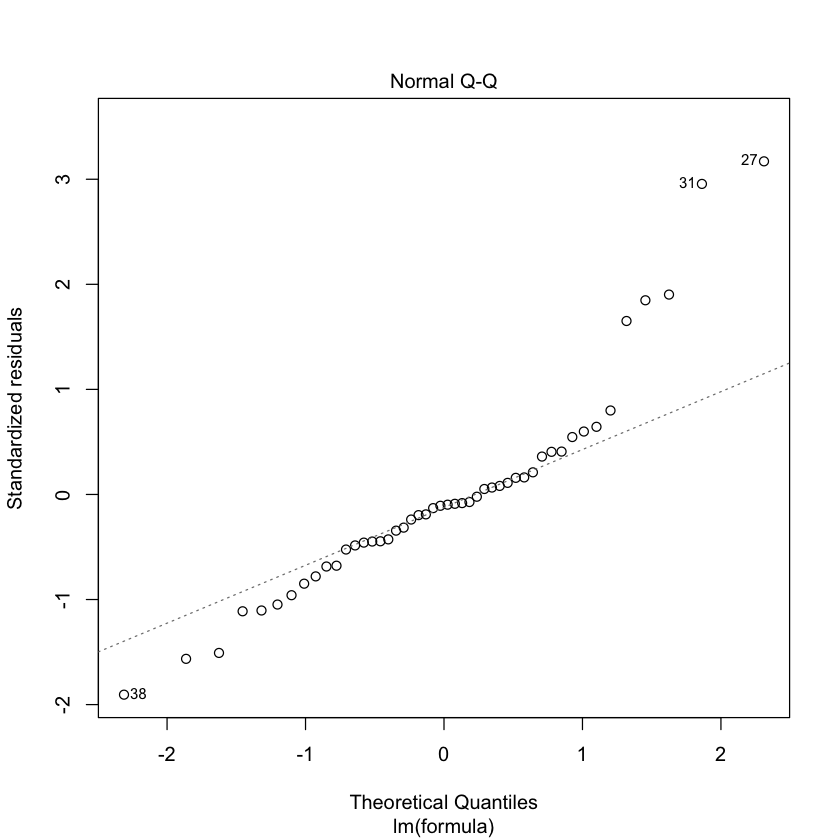

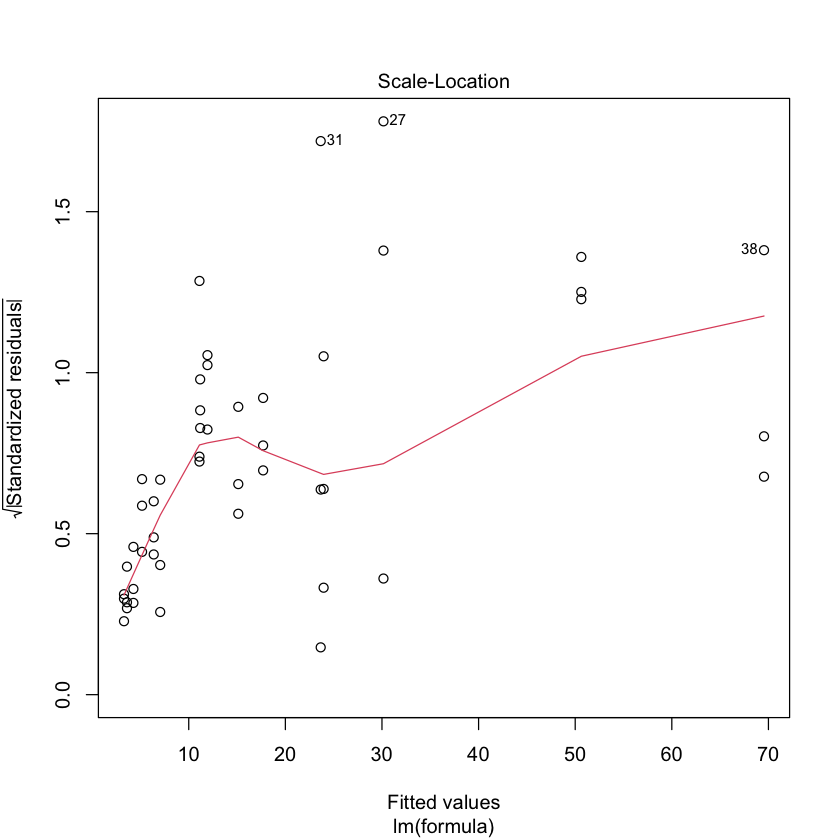

NULL

Call:
lm(formula = formula, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-14.3431  -4.2373  -0.8746   2.0506  27.5324 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   11.9378     3.5377   3.374 0.001654 ** 
sqrt(dose)                     3.3257     0.3877   8.578 1.33e-10 ***
genotypehet                   -6.7711     5.0030  -1.353 0.183523    
genotypehet+RUNX3             -0.7548     5.0030  -0.151 0.880844    
genotypeKO                    -8.6387     5.0030  -1.727 0.091939 .  
sqrt(dose):genotypehet        -2.2407     0.5483  -4.086 0.000205 ***
sqrt(dose):genotypehet+RUNX3  -1.0482     0.5483  -1.912 0.063115 .  
sqrt(dose):genotypeKO         -3.1481     0.5483  -5.741 1.09e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9.074 on 40 degrees of freedom
Multiple R-squared:  0.823,	Adjusted R-squared:  0.792 
F-statistic: 26.57 on 7 

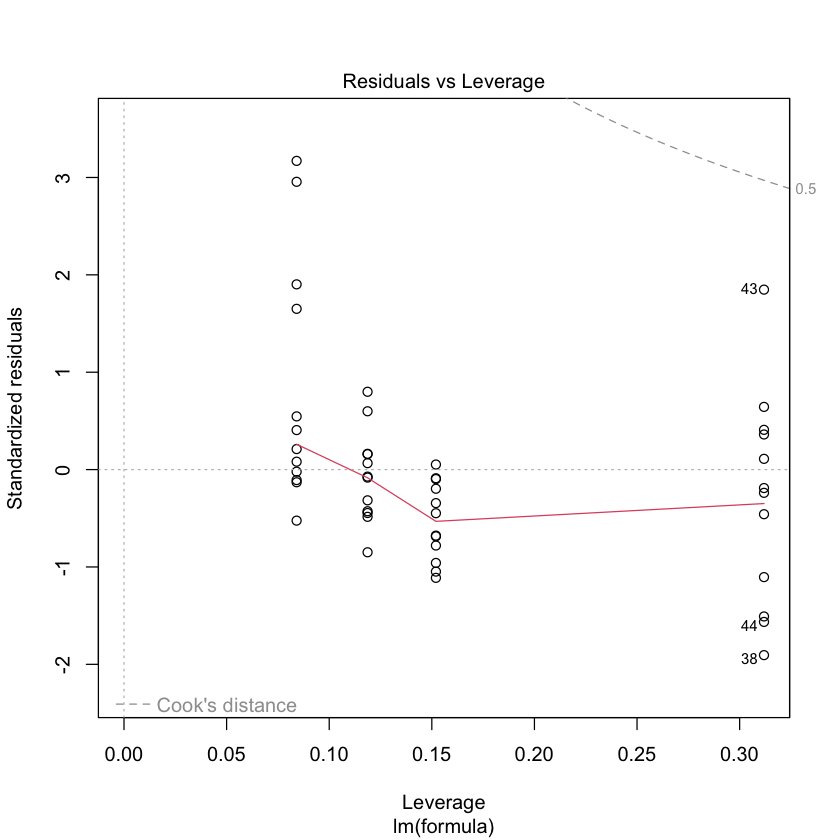

In [21]:
# "Fig5B_FACS_OCI-Ly8" 

data <- read.csv(file = paste0("./input/"
                                  ,"Fig5B_FACS_OCI-Ly8.tsv"
                                  )
                    ,sep = "\t"
                     ,dec = ","
                    ,header = TRUE)
data$genotype <- factor(data$genotype
                        , levels=c("WT", "het", "het+RUNX3", "KO" )
#,ordered = TRUE
                       )
print(str(data))

fit <- run_regression("Fig5B_FACS_OCI-Ly8"
                       ,formula = value~sqrt(dose)*genotype
                      ,data = data
                       ,export_results = TRUE
                       )


In [20]:
run_statistics("Fig5E_FACS_OCI-Ly8"
              ,groups_to_test = c("het vs WT"
                                  ,"het+RUNX3 vs WT"
                                  ,"KO vs WT"
                                 )
              )

'data.frame':	20 obs. of  5 variables:
 $ value  : num  19.8 30.12 18.37 7.01 23.37 ...
 $ group  : chr  "WT" "WT" "WT" "WT" ...
 $ tec_rep: logi  NA NA NA NA NA NA ...
 $ bio_rep: chr  "CD8.1" "CD8.2" "CD8.3" "CD8.333" ...
 $ date   : int  20211201 20211207 20211220 20220316 20220318 20211201 20211207 20211220 20220316 20220318 ...
NULL

[1] "we have following groups in the data:"
[1] "WT"        "het"       "het+RUNX3" "KO"       

[1] "data are paired observations"

[1] "run Shapiro test to check the assumption of the distribution normality..."
[1] "WT"
[1] "normal"
[1] "het"
[1] "non-normal"
[1] "het+RUNX3"
[1] "normal"
[1] "KO"
[1] "non-normal"
[1] "overall distribution is:"
[1] "non-normal"

[1] "run Fligner-Killeen test to check the assumption of the variance homogeneity..."
[1] "overall variance is:"
[1] "stable"

[1] "Since the normality of distribution assumption is not met and the homogeneity of variace assumption is met, we use the Mann-Whitney U-test."

[1] "Since we have 

In [23]:
run_statistics("FigS1B_FACS"
              ,groups_to_test = c("MUT vs WT")
              )

'data.frame':	12 obs. of  6 variables:
 $ value  : num  17.4 14.5 13 21 18 14.4 5.89 4.06 2.98 9.16 ...
 $ group  : chr  "WT" "WT" "WT" "WT" ...
 $ group2 : chr  "OCI-Ly1" "OCI-Ly1" "OCI-Ly1" "OCI-Ly8" ...
 $ tec_rep: int  1 2 3 1 2 3 1 2 3 1 ...
 $ bio_rep: logi  NA NA NA NA NA NA ...
 $ date   : logi  NA NA NA NA NA NA ...
NULL

[1] "we have following groups in the data:"
[1] "WT"  "MUT"


[1] "run Shapiro test to check the assumption of the distribution normality..."
[1] "WT"
[1] "normal"
[1] "MUT"
[1] "normal"
[1] "overall distribution is:"
[1] "normal"

[1] "run Bartlett test to check the assumption of the variance homogeneity..."
[1] "overall variance is:"
[1] "stable"

[1] "Since the normality of distribution assumption is met and the homogeneity of variace assumption is met, we use the t-test."


[1] "We are doing the comparison of the following group(s):"
[1] "MUT vs WT"

          comparison     p.value
MUT vs WT  MUT vs WT 0.001363183


In [25]:
run_statistics("FigS2D_qPCR_OCI-Ly1_raw"
              ,groups_to_test = c("het vs WT"
                                  ,"het+RUNX3 vs WT"
                                  ,"KO vs WT"
                                 )
               ,adjustment_method = "fdr"
              )

'data.frame':	12 obs. of  5 variables:
 $ value  : num  7.46 6.16 6.17 9.1 8.43 ...
 $ group  : chr  "WT" "WT" "WT" "het" ...
 $ tec_rep: int  1 2 3 1 2 3 1 2 3 1 ...
 $ bio_rep: logi  NA NA NA NA NA NA ...
 $ date   : logi  NA NA NA NA NA NA ...
NULL

[1] "we have following groups in the data:"
[1] "WT"        "het"       "het+RUNX3" "KO"       


[1] "run Shapiro test to check the assumption of the distribution normality..."
[1] "WT"
[1] "non-normal"
[1] "het"
[1] "normal"
[1] "het+RUNX3"
[1] "non-normal"
[1] "KO"
[1] "normal"
[1] "overall distribution is:"
[1] "non-normal"

[1] "run Fligner-Killeen test to check the assumption of the variance homogeneity..."
[1] "overall variance is:"
[1] "stable"

[1] "Since the normality of distribution assumption is not met and the homogeneity of variace assumption is met, we use the Mann-Whitney U-test."


[1] "We are doing the comparison of the following group(s):"
[1] "het vs WT"       "het+RUNX3 vs WT" "KO vs WT"       

                     

In [11]:
run_statistics("FigS2E_FACS_OCI-Ly1"
              ,groups_to_test = c("het vs WT"
                                  ,"het+RUNX3 vs WT"
                                  ,"KO vs WT"
                                 )
              )

'data.frame':	12 obs. of  5 variables:
 $ value  : num  23.3 16.6 14.9 7.01 3.96 5.18 12.7 7.01 11.9 8.99 ...
 $ group  : chr  "WT" "WT" "WT" "het" ...
 $ tec_rep: int  1 2 3 1 2 3 1 2 3 1 ...
 $ bio_rep: logi  NA NA NA NA NA NA ...
 $ date   : logi  NA NA NA NA NA NA ...
NULL

[1] "we have following groups in the data:"
[1] "WT"        "het"       "het+RUNX3" "KO"       


[1] "run Shapiro test to check the assumption of the distribution normality..."
[1] "WT"
[1] "normal"
[1] "het"
[1] "normal"
[1] "het+RUNX3"
[1] "normal"
[1] "KO"
[1] "normal"
[1] "overall distribution is:"
[1] "normal"

[1] "run Bartlett test to check the assumption of the variance homogeneity..."
[1] "overall variance is:"
[1] "stable"

[1] "Since the normality of distribution assumption is met and the homogeneity of variace assumption is met, we use the t-test."


[1] "We are doing the comparison of the following group(s):"
[1] "het vs WT"       "het+RUNX3 vs WT" "KO vs WT"       

                     comparison

In [26]:
sessionInfo()

R version 4.2.2 (2022-10-31)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Catalina 10.15.7

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.2/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.2/Resources/lib/libRlapack.dylib

locale:
[1] C/UTF-8/C/C/C/C

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] coin_1.4-3     survival_3.4-0

loaded via a namespace (and not attached):
 [1] pillar_1.9.0      compiler_4.2.2    base64enc_0.1-3   tools_4.2.2      
 [5] digest_0.6.33     uuid_1.1-0        jsonlite_1.8.7    evaluate_0.21    
 [9] lifecycle_1.0.3   lattice_0.20-45   rlang_1.1.1       Matrix_1.5-3     
[13] IRdisplay_1.1     cli_3.6.1         IRkernel_1.3.1    parallel_4.2.2   
[17] mvtnorm_1.2-3     libcoin_1.0-10    fastmap_1.1.1     repr_1.1.4       
[21] vctrs_0.6.3       stats4_4.2.2      grid_4.2.2        glue_1.6.2       
[2